In [1]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_shape = (64, 64)
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=False)
n_samples, n_features = faces.shape
# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

<IPython.core.display.Javascript object>


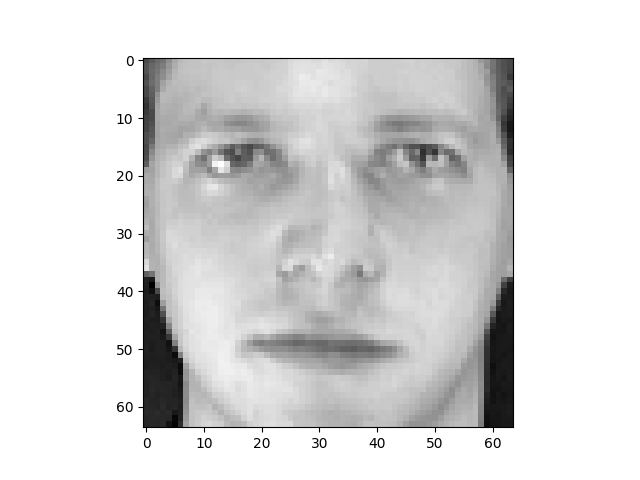

In [3]:
%matplotlib notebook
plt.imshow(faces[0].reshape(image_shape), cmap=plt.cm.gray)
plt.show()

In [102]:
y = np.zeros((1, n_samples))
c = 0
for i in range(n_samples):
    y[0][i] = c
    if (i+1)%10 == 0: c+=1

In [161]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='randomized',  whiten=True)
pcaFaces = pca.fit_transform(faces)

<IPython.core.display.Javascript object>


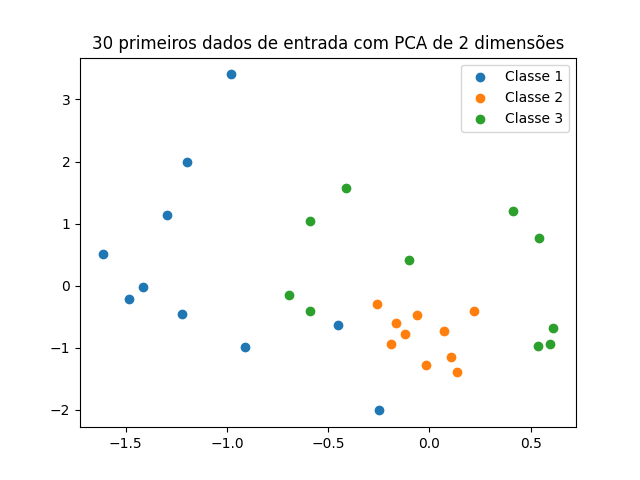

In [190]:
%matplotlib notebook
y_te = y.reshape(-1)
plt.scatter(pcaFaces[y_te==0, 0], pcaFaces[y_te==0, 1], label = 'Classe 1')
plt.scatter(pcaFaces[y_te==1, 0], pcaFaces[y_te==1, 1], label = 'Classe 2')
plt.scatter(pcaFaces[y_te==2, 0], pcaFaces[y_te==2, 1], label = 'Classe 3')
plt.title('30 primeiros dados de entrada com PCA de 2 dimensões')
plt.legend()
plt.show()

In [188]:
pcaFaces[y_te==1, 1]

array([-0.3043959 , -0.9426664 , -0.7737915 , -1.1491276 , -0.60818934,
       -1.2757766 , -0.40847012, -0.73337907, -1.3904843 , -0.47233942],
      dtype=float32)

In [106]:
def calcula_K(u, h):
    return (1/np.sqrt(2*np.pi*h*h))*np.exp(-0.5*u**2)

In [107]:
def prob_ponto_dado_classe(ponto_analisado, pontos_classe, h):
    N = pontos_classe.shape[0]
    px = []
    xi = ponto_analisado.reshape(1, -1)
    kxiall = 0
    for j in range(N):
        xj = pontos_classe[j, :]
        u = np.sqrt(np.sum((xi-xj)**2))/h
        kxiall = kxiall+calcula_K(u, h)
    px.append(kxiall)
    px = np.array(px)/N
    return px

In [108]:
def classe(ponto_analisado, pontos, distribuicoes, h=0.1):
    dist_dif = np.unique(distribuicoes)
    N = pontos.shape[0]
    px = []
    for dist in dist_dif:
        pontos_por_classe = pontos[distribuicoes==dist]
        prob_classe = prob_ponto_dado_classe(ponto_analisado, pontos_por_classe, h)
        px.append(pontos_por_classe.shape[0]/N * prob_classe)
    return(px.index(max(px)))

In [120]:
%matplotlib notebook
from copy import copy
from math import floor
best = 0
best_class = 0
acc = []
best_n = 0
n_comp = list(range(100))

for n in n_comp:
    pca = PCA(n_components=n+1, svd_solver='randomized')
    pcaFaces = pca.fit_transform(faces)
    wrong = []
    right = []
    in_class = []
    
    for i in range(10):
        data = np.concatenate([pcaFaces, y.reshape(-1, 1)], 1)
        np.random.shuffle(data)
        train = data[:int(0.5*n_samples)]
        test = data[int(0.5*n_samples):]
        in_class.append([])
        
        for point in test[:, :-1]:
            in_class[i].append(classe(point, train[:, :-1], train[:, -1], 0.1))
        accuracy = np.where(in_class == test[:, -1], 1, 0)
        right.append((np.count_nonzero(accuracy))/len(test)*100)
        wrong.append((len(test) - right[i])/len(test)*100)
    
    acc.append(np.mean(right))
    
    if np.mean(right) > best:
        best = np.mean(right)
        best_class = in_class
        best_n = n

<IPython.core.display.Javascript object>


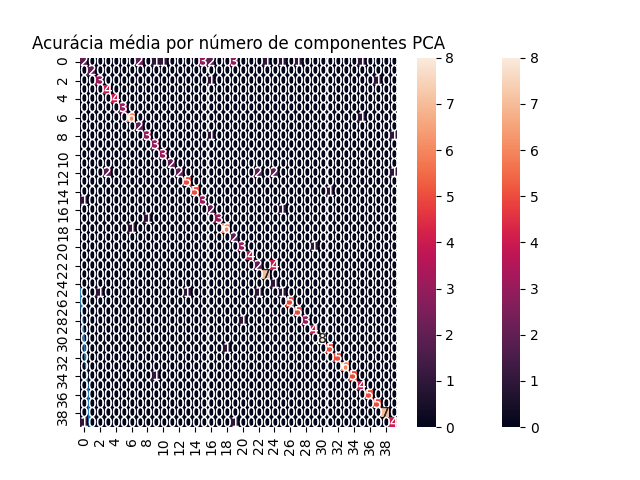

In [137]:
%matplotlib notebook
plt.plot(acc)
plt.title('Acurácia média por número de componentes PCA')
plt.xlabel('Número de componentes PCA')
plt.ylabel('Acurácia média (%)')
plt.ylim((30,100))
plt.xlim(0,100)
plt.show()

In [191]:
best

84.9

In [195]:
pca = PCA(n_components=9, svd_solver='randomized')
pcaFaces = pca.fit_transform(faces)
wrong = []
right = []
in_class = []

for i in range(10):
    data = np.concatenate([pcaFaces, y.reshape(-1, 1)], 1)
    np.random.shuffle(data)
    train = data[:int(0.5*n_samples)]
    test = data[int(0.5*n_samples):]
    in_class.append([])

    for point in test[:, :-1]:
        in_class[i].append(classe(point, train[:, :-1], train[:, -1], 0.1))
    accuracy = np.where(in_class == test[:, -1], 1, 0)
    right.append((np.count_nonzero(accuracy))/len(test)*100)
    wrong.append((len(test) - right[i])/len(test)*100)

In [198]:
print(np.mean(right))
print(np.std(right))

84.3
8.902808545621994


<IPython.core.display.Javascript object>


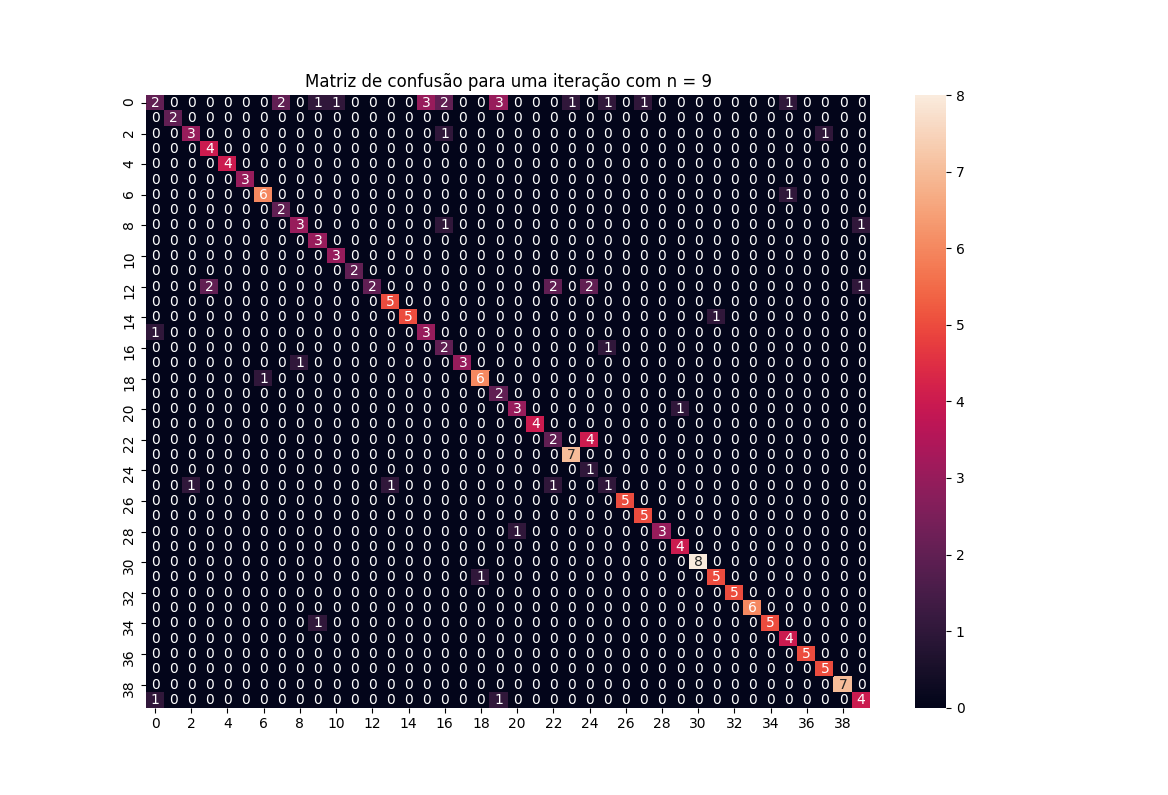

In [159]:
%matplotlib notebook
import seaborn as sn
from sklearn.metrics import confusion_matrix
df_cm = confusion_matrix(np.array(in_class).reshape(-1,1), test[:,-1].reshape(-1,1))
sn.heatmap(df_cm, annot=True)
plt.title('Matriz de confusão para uma iteração com n = 9')
plt.show()